# Single-Atom Local Gaussian Fit
This minimal notebook builds a single-atom projected potential, places one Gaussian beam at the centre, and compares the Gaussian phase with the local potential curvature. We also show a 1D phase cross-section.

In [11]:
# Imports and config
import os
os.environ['JAX_ENABLE_X64'] = '1'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.1'
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from ase import Atoms
import abtem
from abtem.core.energy import energy2wavelength, energy2sigma

from temgym_core.utils import fibonacci_spiral, FresnelPropagator
from temgym_core.components import Detector
from temgym_core.gaussian import GaussianRayBeta
from temgym_core.gaussian_taylor import Potential, FreeSpaceParaxial, run_to_end, evaluate_gaussian_packets_jax_scan
from skimage.restoration import unwrap_phase

jax.config.update('jax_enable_x64', True)
%matplotlib widget

In [12]:
# Build a single-atom projected potential and a Gaussian at the centre
def make_single_atom(symbol='Si', box_A=(20.0, 20.0, 20.0)):
    Lx, Ly, Lz = map(float, box_A)
    return Atoms(
        symbols=symbol,
        positions=[[Lx / 2, Ly / 2, Lz / 2]],
        cell=[Lx, Ly, Lz],
        pbc=False
    )

def projected_potential_2d(
    src,
    sampling_A=0.02,
    parametrization='lobato',
    projection='infinite',
    periodic=False,
    box_A=None,
    slice_thickness=1.0
):
    # Use abTEM to compute projected potential and return V2d with sampling/origin matching temgym Potential
    if isinstance(src, Atoms):
        pot = abtem.Potential(
            src,
            sampling=sampling_A,
            parametrization=parametrization,
            projection=projection,
            periodic=periodic,
            slice_thickness=slice_thickness,
            box=None if box_A is None else tuple(map(float, box_A))
        )
        proj = pot.project().compute()
        V2d = np.asarray(proj.array)
        sy, sx = proj.sampling
    elif hasattr(src, 'project') and hasattr(src, 'compute'):
        proj = src.project().compute()
        V2d = np.asarray(proj.array)
        sy, sx = proj.sampling
    else:
        raise TypeError('Unsupported src for projected_potential_2d')
    ny, nx = V2d.shape
    Lx, Ly = nx * sx, ny * sy
    x0, y0 = -Lx / 2.0, -Ly / 2.0
    return V2d, float(sx), float(sy), float(x0), float(y0)

In [13]:
# Parameters
accel_V = 200_000
wavelength = energy2wavelength(accel_V)
sigma = energy2sigma(accel_V)
k = 2 * jnp.pi / wavelength
# Single atom
Lx, Ly, Lz = 2.0, 2.0, 2.0
atoms = make_single_atom('Si', box_A=(Lx, Ly, Lz))
V2d, sx, sy, x0, y0 = projected_potential_2d(atoms, sampling_A=0.05, parametrization='lobato', projection='infinite', periodic=False, box_A=(Lx, Ly, Lz))

potential = Potential(z=0.0, V=jnp.asarray(V2d, dtype=jnp.float64), sx=sx, sy=sy, x0=x0, y0=y0, order=3)

# Build a small detector/grid for field evaluation
W = Lx  # window size in Å
Nx, Ny = V2d.shape[1], V2d.shape[0]
dx = W / Nx
dy = W / Ny
grid = Detector(z=0.0, pixel_size=(dy, dx), shape=(Ny, Nx))

extent = (x0, x0 + Nx * dx, y0, y0 + Ny * dy)

w0 = 0.1
num_rays = 10000
rx, ry = fibonacci_spiral(num_rays, radius=1.0)
rx = rx
lam = jnp.ones(num_rays) * wavelength
k0 = 2 * jnp.pi / lam
C0 = jnp.ones(num_rays) * (1.0 + 0.0j)
eta = jnp.zeros((num_rays, 2), dtype=jnp.complex128)
scale = -1j * (2.0 / (k0 * w0**2))
Qinv0 = scale[..., None, None] * jnp.eye(2, dtype=jnp.complex128)
ray_in = GaussianRayBeta(x=rx, 
                         y=ry, 
                         dx=jnp.zeros_like(rx), 
                         dy=jnp.zeros_like(ry), 
                         z=jnp.zeros_like(rx), 
                         pathlength=jnp.zeros_like(rx), 
                         Q_inv=Qinv0, 
                         eta=eta, 
                         C=C0, 
                         voltage=jnp.full_like(rx, accel_V))
ray_in = ray_in.to_vector()

distance=1.0
free_space = FreeSpaceParaxial(z=0.0, distance=distance)
components = [potential, free_space]


[########################################] | 100% Completed | 108.27 ms


Gaussian Solution

In [14]:
input_probe = evaluate_gaussian_packets_jax_scan(ray_in, grid, batch_size=32)
ray_after_atom = run_to_end(ray_in, [potential])
input_probe_times_atom = evaluate_gaussian_packets_jax_scan(ray_after_atom, grid, batch_size=32)
ray_propagated = run_to_end(ray_in, components)
input_probe_propagated = evaluate_gaussian_packets_jax_scan(ray_propagated, grid, batch_size=32)

Fourier Solution

In [15]:
fft_input = input_probe * np.exp(1j * potential.V * sigma)
fft_solution = FresnelPropagator(fft_input, L=Lx, wavelength=wavelength, z=distance)

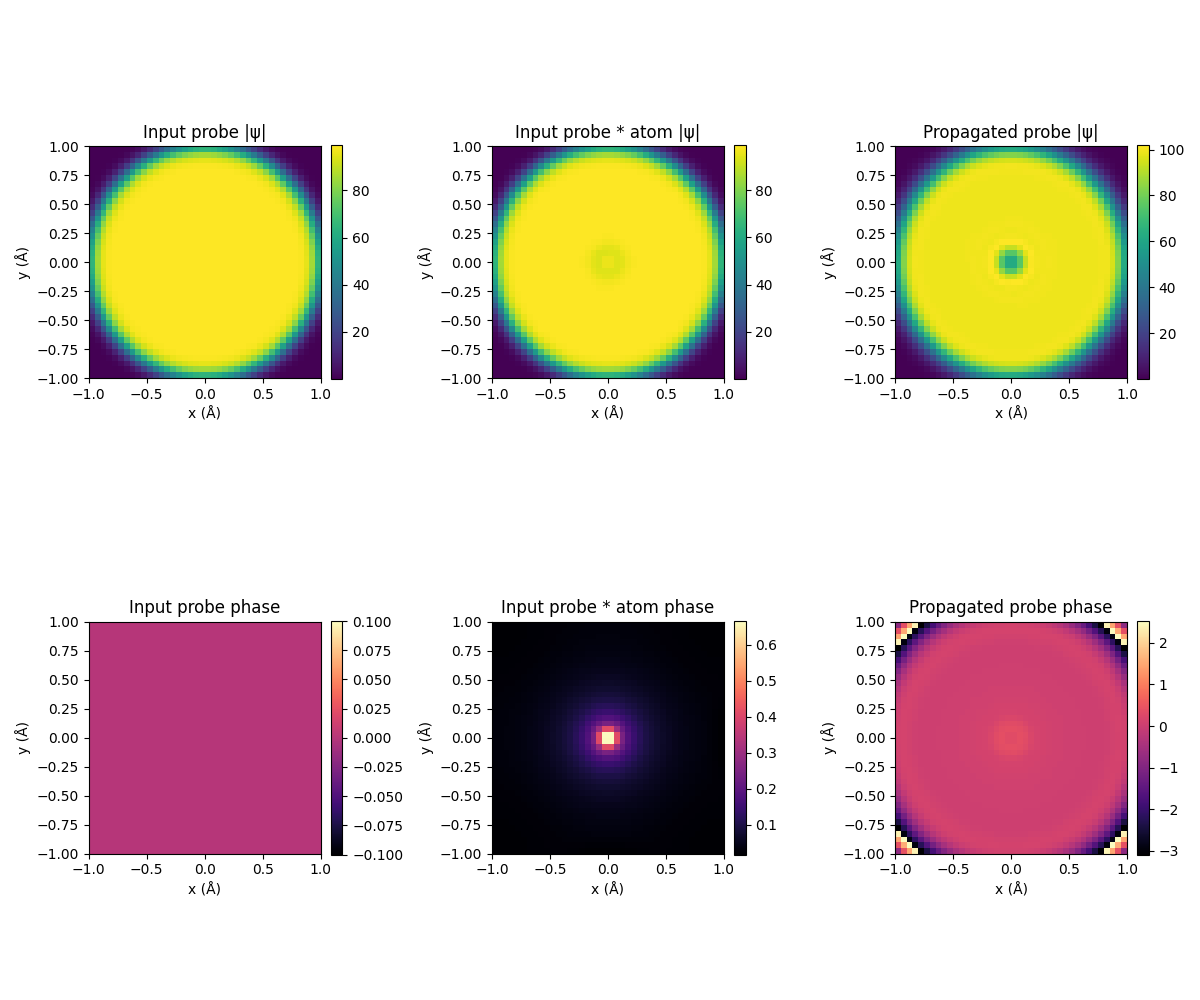

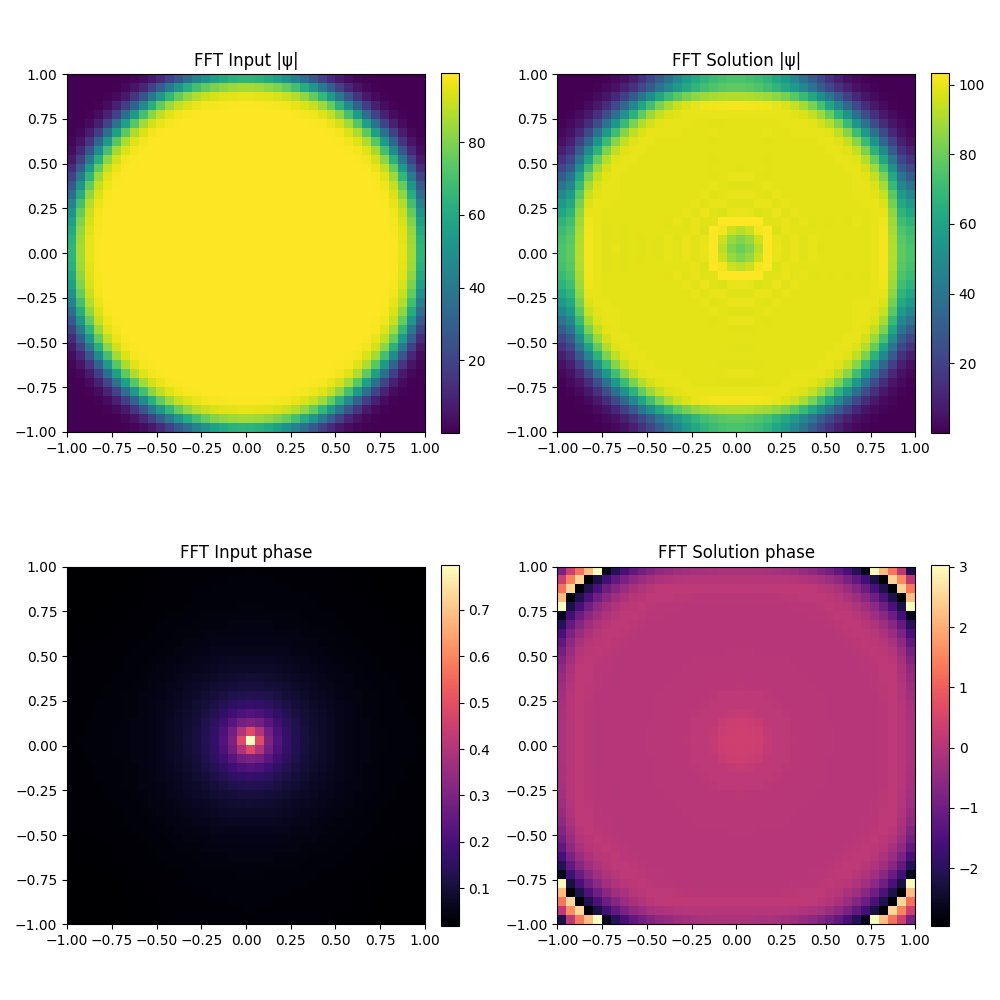

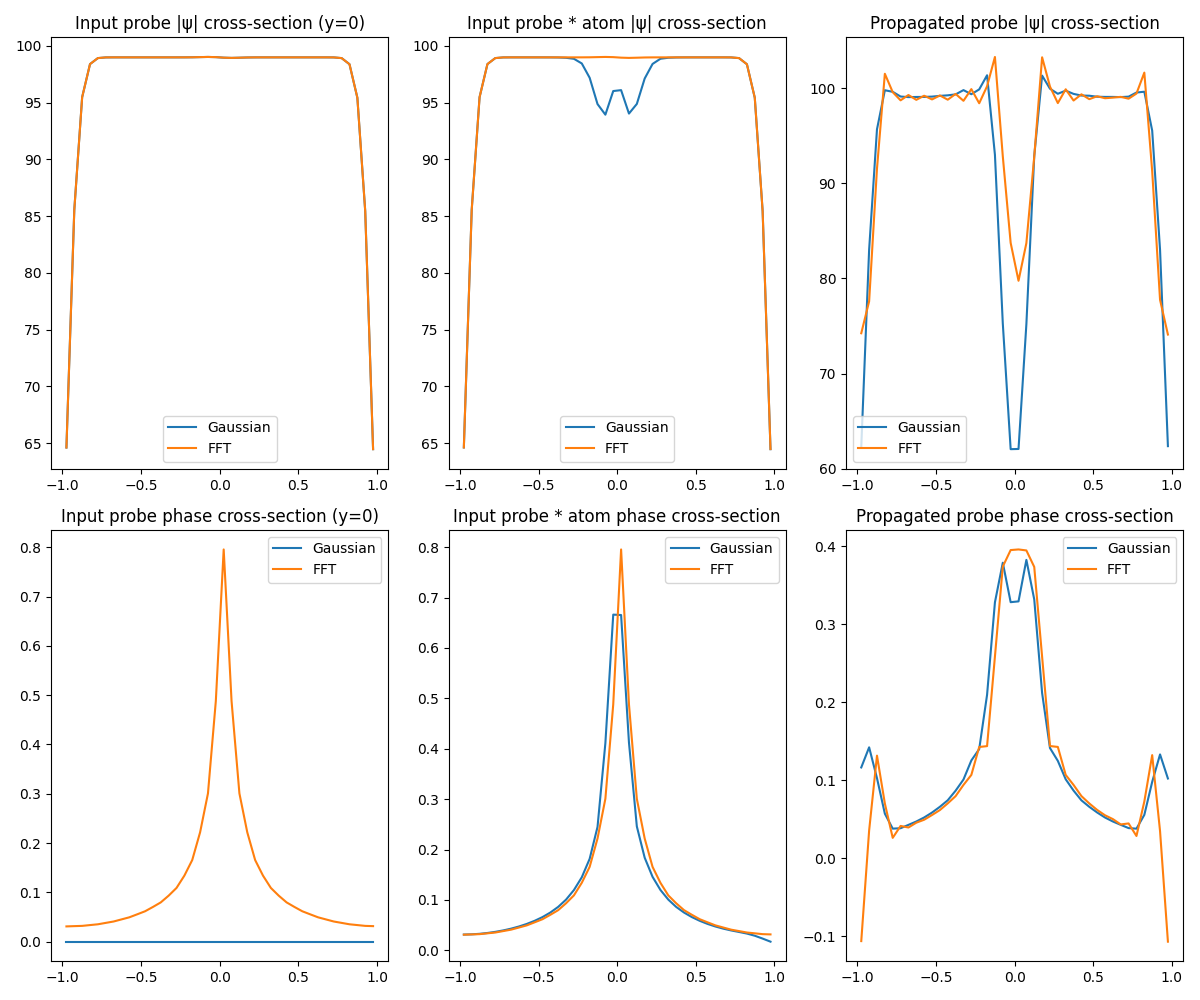

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(12, 10))

# Input probe amplitude and phase
im0 = axes[0, 0].imshow(np.abs(np.asarray(input_probe)), extent=extent, origin='lower', cmap='viridis')
axes[0, 0].set_title('Input probe |ψ|')
axes[0, 0].set_xlabel('x (Å)')
axes[0, 0].set_ylabel('y (Å)')
fig.colorbar(im0, ax=axes[0, 0], fraction=0.046, pad=0.04)

im1 = axes[1, 0].imshow(np.angle(np.asarray(input_probe)), extent=extent, origin='lower', cmap='magma')
axes[1, 0].set_title('Input probe phase')
axes[1, 0].set_xlabel('x (Å)')
axes[1, 0].set_ylabel('y (Å)')
fig.colorbar(im1, ax=axes[1, 0], fraction=0.046, pad=0.04)

# Input probe * atom amplitude and phase
im2 = axes[0, 1].imshow(np.abs(np.asarray(input_probe_times_atom)), extent=extent, origin='lower', cmap='viridis')
axes[0, 1].set_title('Input probe * atom |ψ|')
axes[0, 1].set_xlabel('x (Å)')
axes[0, 1].set_ylabel('y (Å)')
fig.colorbar(im2, ax=axes[0, 1], fraction=0.046, pad=0.04)

im3 = axes[1, 1].imshow(np.angle(np.asarray(input_probe_times_atom)), extent=extent, origin='lower', cmap='magma')
axes[1, 1].set_title('Input probe * atom phase')
axes[1, 1].set_xlabel('x (Å)')
axes[1, 1].set_ylabel('y (Å)')
fig.colorbar(im3, ax=axes[1, 1], fraction=0.046, pad=0.04)

# Propagated probe amplitude and phase
im4 = axes[0, 2].imshow(np.abs(np.asarray(input_probe_propagated)), extent=extent, origin='lower', cmap='viridis')
axes[0, 2].set_title('Propagated probe |ψ|')
axes[0, 2].set_xlabel('x (Å)')
axes[0, 2].set_ylabel('y (Å)')
fig.colorbar(im4, ax=axes[0, 2], fraction=0.046, pad=0.04)

im5 = axes[1, 2].imshow(np.angle(np.asarray(input_probe_propagated)), extent=extent, origin='lower', cmap='magma')
axes[1, 2].set_title('Propagated probe phase')
axes[1, 2].set_xlabel('x (Å)')
axes[1, 2].set_ylabel('y (Å)')
fig.colorbar(im5, ax=axes[1, 2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# FFT comparison
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# FFT Input
im0 = axes[0, 0].imshow(np.abs(np.asarray(fft_input)), extent=extent, origin='lower', cmap='viridis')
axes[0, 0].set_title('FFT Input |ψ|')
fig.colorbar(im0, ax=axes[0, 0], fraction=0.046, pad=0.04)

im1 = axes[1, 0].imshow(np.angle(np.asarray(fft_input)), extent=extent, origin='lower', cmap='magma')
axes[1, 0].set_title('FFT Input phase')
fig.colorbar(im1, ax=axes[1, 0], fraction=0.046, pad=0.04)

# FFT Solution
im2 = axes[0, 1].imshow(np.abs(np.asarray(fft_solution)), extent=extent, origin='lower', cmap='viridis')
axes[0, 1].set_title('FFT Solution |ψ|')
fig.colorbar(im2, ax=axes[0, 1], fraction=0.046, pad=0.04)

im3 = axes[1, 1].imshow(np.angle(np.asarray(fft_solution)), extent=extent, origin='lower', cmap='magma')
axes[1, 1].set_title('FFT Solution phase')
fig.colorbar(im3, ax=axes[1, 1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# Cross-sections at y=0
x1d, y1d = grid.coords_1d
y_idx = np.argmin(np.abs(y1d - 0.0))

fig, axes = plt.subplots(2, 3, figsize=(12, 10))

# Input probe cross-sections
axes[0, 0].plot(x1d, np.abs(np.asarray(input_probe))[y_idx, :], label='Gaussian')
axes[0, 0].plot(x1d, np.abs(np.asarray(fft_input))[y_idx, :], label='FFT')
axes[0, 0].set_title('Input probe |ψ| cross-section (y=0)')
axes[0, 0].legend()

axes[1, 0].plot(x1d, np.angle(np.asarray(input_probe))[y_idx, :], label='Gaussian')
axes[1, 0].plot(x1d, np.angle(np.asarray(fft_input))[y_idx, :], label='FFT')
axes[1, 0].set_title('Input probe phase cross-section (y=0)')
axes[1, 0].legend()

# Input probe * atom cross-sections
axes[0, 1].plot(x1d, np.abs(np.asarray(input_probe_times_atom))[y_idx, :], label='Gaussian')
axes[0, 1].plot(x1d, np.abs(np.asarray(fft_input))[y_idx, :], label='FFT')
axes[0, 1].set_title('Input probe * atom |ψ| cross-section')
axes[0, 1].legend()

axes[1, 1].plot(x1d, np.angle(np.asarray(input_probe_times_atom))[y_idx, :], label='Gaussian')
axes[1, 1].plot(x1d, np.angle(np.asarray(fft_input))[y_idx, :], label='FFT')
axes[1, 1].set_title('Input probe * atom phase cross-section')
axes[1, 1].legend()

# Propagated probe cross-sections
axes[0, 2].plot(x1d, np.abs(np.asarray(input_probe_propagated))[y_idx, :], label='Gaussian')
axes[0, 2].plot(x1d, np.abs(np.asarray(fft_solution))[y_idx, :], label='FFT')
axes[0, 2].set_title('Propagated probe |ψ| cross-section')
axes[0, 2].legend()

axes[1, 2].plot(x1d, np.angle(np.asarray(input_probe_propagated))[y_idx, :], label='Gaussian')
axes[1, 2].plot(x1d, np.angle(np.asarray(fft_solution))[y_idx, :], label='FFT')
axes[1, 2].set_title('Propagated probe phase cross-section')
axes[1, 2].legend()

plt.tight_layout()
plt.show()